# Helpers

In [1]:
def get_activations(img, base_model, activation = 1, print_ = False):
    """
    Returns ReLUs of layer specified by parameter activation

    :param img: np.array
    :param base_model: Keras Model
    :param activation_: int
    :return:
    """
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    if print_: print("Shape of input:", img.shape)
    
    model = Model(inputs=base_model.input,
                  outputs=base_model.get_layer('activation_' + str(activation)).output)

    activation = model.predict(img)
    if print_: print("Shape of output:", activation.shape)
    
    return activation
  
def remove_specific_label(X, y, label = 1):
    not_label = y != label
    return X[not_label], y[not_label]
  
def intialize_train(X_train, y_train, X_val, y_val, params):
    
    dim = params['dim']
    neurons = params.pop('neurons', 512)
    batch_size = params.pop('batch_size', 20)
    epochs = params.pop('epochs', 20)
    learning_rate = params.pop('lr', 2e-5)
    
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim= dim[1] * dim[2] * dim[3]))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val))
    
    return history, model
  
def get_indices_of_wrong_classified_images(X, y, test_indices, model):
    test_idx_wrong_classified = model.predict_classes(X).flatten() != y
    img_wrong_classified = test_indices[test_idx_wrong_classified]
    return img_wrong_classified

  
  
import pickle

def save_obj(obj, fullpath):
    with open(fullpath + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fullpath):
    with open(fullpath + '.pkl', 'rb') as f:
        return pickle.load(f)
      
      
def save_keras_model(model, path, fold, res):

    fullpath = os.path.join(path, 'model' + '_res' + str(res) + '_fold' + str(fold))
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(fullpath + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fullpath + ".h5")
    print("Saved model to disk")


# RestNetActivations and Fully Connected layers

IDEAS:
* data augmentation
* load images on batches (generator)
* variable architecture for different resolutions (layers, epochs, etc)
* show example images for every category and every label
* show images on which the algorithm fails
* what happens with the ResNet architecture for very small images?
* cross validation accuracy and std
* have more images, let's have on the order of 2000 images
* use the label 1 images as test set
* calculate activations and then train networks

In [20]:
pip install python-dotenv

In [2]:
# pip install git+https://github.com/qubvel/classification_models.git
# potentially with smaller pretrained ResNet architectures
# from classification_models.resnet import ResNet18, ResNet34, preprocess_input

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import gc
import numpy as np
import pandas as pd
import sys
import os
import datetime
import math

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [4]:
try: # if running on COLAB
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/My Drive/Colab/MasterThesis/'
    PATH_IMG = "/content/drive/My Drive/MFP - Satellogic/images/"
    
    # confirm GPU is available
    #device_name = tf.test.gpu_device_name()
    #if device_name != '/device:GPU:0':
    #    raise SystemError('GPU device not found')

except:
    from dotenv import load_dotenv
    sys.path.append("../Library/")
    import image_manipulation as ima
    PATH = os.path.join(os.getenv('GDRIVE_FOLDER'), 'Colab/MasterThesis')
    PATH_IMG = os.path.join(os.getenv('GDRIVE_FOLDER'), 'MFP - Satellogic/images/')

In [5]:
PATH_DATA = os.path.join(PATH, 'Data/')
PATH_LIB = os.path.join(PATH, 'Library/')
PATH_MOD = os.path.join(PATH, 'Models/')
PATH_NOTE = os.path.join(PATH, 'Notebooks/')
sys.path.append(PATH_LIB)

print("Folders content:")
print("PATH:\t\t", os.listdir(PATH))
print("PATH DATA:\t", os.listdir(PATH_DATA))
print("PATH LIBRARY:\t", os.listdir(PATH_LIB))
print("PATH MODELS:\t", os.listdir(PATH_MOD))
print("PATH NOTEBOOKS:\t", os.listdir(PATH_NOTE))
print("PATH IMAGES:\t", os.listdir(PATH_IMG))

Folders content:
PATH:		 ['.DS_Store', 'Icon\r', 'Library', 'Models', 'Results_0.3m_excl_label1', '.env', 'Data', 'Notebooks']
PATH DATA:	 ['result_res2.7.csv', 'result_res2.4.csv', 'result_res0.6.csv', 'X_activations_res0.3.npy', 'result_res4.2.csv', 'result_res2.1.csv', 'X_act_res1.8.npy', '.DS_Store', 'Icon\r', 'X_act_res3.9.npy', 'result_res4.5.csv', 'X_act_res4.8.npy', 'result_res1.5.csv', 'result_res3.6.csv', 'result_res3.3.csv', 'result_res3.0.csv', 'result_res1.2.csv', 'X_act_res0.9.npy', 'X_act_res2.7.npy', 'y_images_res0.3.npy', 'X_act_res2.4.npy', 'X_act_res0.6.npy', 'X_act_res4.2.npy', 'X_act_res2.1.npy', 'result_res1.8.csv', 'X_images_res0.3.npy', 'X_act_res4.5.npy', 'result_res3.9.csv', 'result_res4.8.csv', 'X_act_res3.6.npy', 'X_act_res1.5.npy', 'X_act_res3.3.npy', 'X_act_res3.0.npy', 'result_res0.9.csv', 'X_act_res1.2.npy', '1m']
PATH LIBRARY:	 ['image_download.py', 'deep_learning.py', '.DS_Store', 'Icon\r', 'generate_dataset.py', 'IO.py', '__init__.py', '__pycache__', 

In [6]:
%load_ext autoreload
%autoreload 2
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

In [7]:
def print_time(string=''):
    print('', str(datetime.datetime.today())[:22], string)
    return

## Train complete network from source images

### Load Data

In [8]:
X_name = 'X_images_res0.3.npy'
y_name = 'y_images_res0.3.npy'

X_base, y = np.load(os.path.join(PATH_DATA, X_name)), np.load(os.path.join(PATH_DATA, y_name), allow_pickle = True)

### Resolutions

In [9]:
base_res = 0.3
base_size = 512
N_RES = 17

sizes = {base_res: (base_size, base_size)}
for factor in range(2, N_RES):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("Sizes dictionary:\n", sizes)

Sizes dictionary:
 {0.3: (512, 512), 0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51), 3.3: (47, 47), 3.6: (43, 43), 3.9: (39, 39), 4.2: (37, 37), 4.5: (34, 34), 4.8: (32, 32)}


### List of all resolutions (including base):

In [10]:
resolutions = [res for res in sizes]
resolutions.sort()
print(resolutions)

[0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0, 3.3, 3.6, 3.9, 4.2, 4.5, 4.8]


### Load base NN model

Load ResNet and set all layers to `trainable = False` and list *activation* layers:

In [11]:
base_model = ResNet50(weights='imagenet',
                      include_top=False)

activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)
print(activation_layers)

Instructions for updating:
Colocations handled automatically by placer.


/Users/peterweber/Programs/anaconda2/envs/tensorflow/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a268eb855778b3df3c7506639542a6af so we will re-download the data.
94658560/94653016 [==============================] - 108s 1us/step
['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44'

In [0]:
#base_model.summary()

# Run DL pipeline for all resolutions

In [15]:
SAVE_RESULT = True
SAVE_MODEL = True
RESOLUTIONS = [resolutions[0]]


N_images = X_base.shape[0]
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=8, random_state = 42)
batch_size = 50
results = []

N_ACTIVATIONS = len(activation_layers)
act_layer = activation_layers[N_ACTIVATIONS-1]

for res in RESOLUTIONS:
 

    ## Degrading
    X = np.array([ima.degrade_image(X_base[i], sizes[res]) for i in range(N_images)])

    ## Activations and Preprocessing
    print("\n--- Getting Activations for resolution", res, "---\n")
    
    ## Load Activations from disk, if exist
    path_act = os.path.join(PATH_DATA, 'X_act_res' + str(res) + '.npy')
    if os.path.exists(path_act):
        print("Loading activations from disk...")
        X_act = np.load(path_act)
    else:
        X_act = get_activations(X[0], base_model, int(activation_layers[-1].split("_")[-1]))
        for i in range(1, X.shape[0], batch_size):
            X_act = np.r_[X_act, get_activations(X[i:i+batch_size], base_model, int(activation_layers[-1].split("_")[-1]))]
        np.save(path_act, X_act)
    X_act = preprocess_input(X_act)

    ## Initialize parameters for CV
    params = {}
    fold = 0
    result_per_res = []
    
    ## Training with CV
    for train, val in kFold.split(X_act, y):
        
        print("\n ---- Processing fold", fold, "at resolution", res, "--- \n")
        
        dim = X_act.shape
        X_train = np.reshape(X_act[train], (X_act[train].shape[0], dim[1] * dim[2] * dim[3]))
        X_val = np.reshape(X_act[val], (X_act[val].shape[0], dim[1] * dim[2] * dim[3]))
        y_train, y_val = y[train], y[val]

        params['dim'] = dim
        params['batch_size'] = batch_size
        params['epochs'] = 30
        params['neurons'] = 256
        
        print_time("training...")
        history, model = intialize_train(X_train, y_train, X_val, y_val, params)
        del X_train, y_train

        print_time("evaluating...")
        loss, acc = model.evaluate(X_val, y_val)
        print('Accuracy:', acc)
        
        # Get indices of wrongly classified images
        img_wrong_classified = get_indices_of_wrong_classified_images(X_val, y_val, val, model)
                
        if SAVE_MODEL: save_keras_model(model, PATH_DATA, fold, res)
        
        result = {
            "wrong_class": img_wrong_classified.tolist(),
            "resolution": res,
            "accuracy": acc,
            "loss": loss,
            "history": history,
            "fold": fold
        }
        del X_val, y_val, model, history
        
        result_per_res.append(result) 
        fold += 1
     
    if SAVE_RESULT: pd.DataFrame(result_per_res).to_csv(os.path.join(PATH_DATA, "result_res" + str(res) + ".csv"), index=False)


gc.collect()

del X
del X_act

print_time("DONE! \n")   


--- Getting Activations for resolution 0.3 ---


 ---- Processing fold 0 at resolution 0.3 --- 

 2019-05-27 13:51:22.92 training...
Train on 1770 samples, validate on 254 samples
Epoch 1/30
1050/1770 [================>.............] - ETA: 46s - loss: 8.0360 - acc: 0.4762

KeyboardInterrupt: 

### Results

In [0]:
res = 0.6
df_results = pd.read_csv(os.path.join(PATH_DATA, "result_res" + str(res) + ".csv"))
for res in resolutions[2:]:
  df_results = df_results.append(pd.read_csv(os.path.join(PATH_DATA, "result_res" + str(res) + ".csv")))

In [17]:
grouped_results = df_results.groupby(['resolution'], as_index=False).agg(
                          {'accuracy':['mean','std']})

grouped_results

resolution  accuracy          
                   mean       std
0         0.6  0.956020  0.015460
1         0.9  0.945164  0.009278
2         1.2  0.939713  0.016617
3         1.5  0.931324  0.014320
4         1.8  0.933287  0.015620
5         2.1  0.918482  0.015055
6         2.4  0.919449  0.013963
7         2.7  0.906605  0.021517
8         3.0  0.902152  0.023152
9         3.3  0.901176  0.017748
10        3.6  0.891759  0.028647
11        3.9  0.885830  0.027689
12        4.2  0.896231  0.023187
13        4.5  0.892276  0.022644
14        4.8  0.876464  0.024623

Accuracy for each resolution:

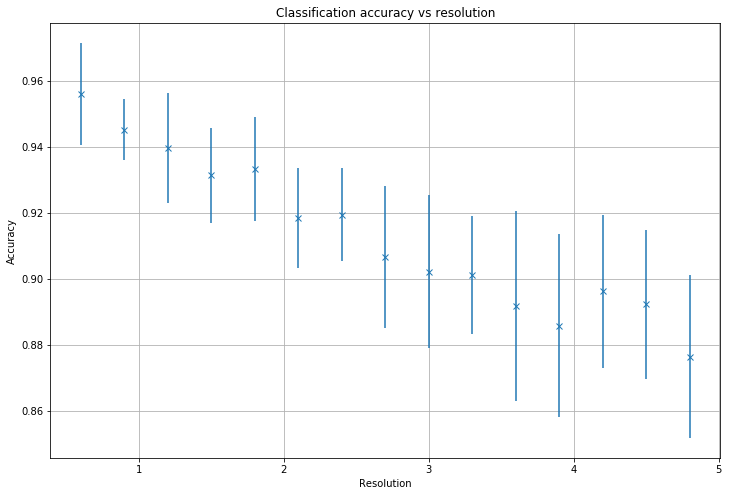

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.errorbar(grouped_results["resolution"], 
            grouped_results.accuracy["mean"], 
            grouped_results.accuracy["std"],
            linestyle='None', marker='x'
           )  
ax.set(
    xlabel="Resolution",
    ylabel="Accuracy",
    title = "Classification accuracy vs resolution"
)
ax.grid()
#ax.legend()

plt.show()
fig.savefig(PATH_NOTE + 'img/acc_vs_res_' + str(datetime.datetime.today())[:16].replace(":",".") + '_.png', bbox_inches='tight')